In [1]:
# Package Imports
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

## Loading Data

In [2]:
train_x = pd.read_csv('data/pulse_data/train_x.csv').to_numpy()
train_y = pd.read_csv('data/pulse_data/train_y.csv').to_numpy()
test_x = pd.read_csv('data/pulse_data/test_x.csv').to_numpy()
test_y = pd.read_csv('data/pulse_data/test_y.csv').to_numpy()
out_of_dist_x = pd.read_csv('data/pulse_data/outOfDist_x.csv').to_numpy()
out_of_dist_y = pd.read_csv('data/pulse_data/outOfDist_y.csv').to_numpy()

print("Shape train_x:", train_x.shape)
print("Shape train_y:", train_y.shape)
print("Shape test_x:", test_x.shape)
print("Shape test_y:", test_y.shape)

Shape train_x: (1000, 2001)
Shape train_y: (1000, 2001)
Shape test_x: (500, 2001)
Shape test_y: (500, 2001)


In [3]:
def plot_data(x, y, name):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()
    
    for i in range(16):
        ax1 = axes[i]
        ax1.plot(x[i], label='Input' if i == 0 else "")
        ax1.plot(y[i], label='Output' if i == 0 else "")
        ax1.set_xticks([])
        ax1.tick_params(axis='y', labelsize=14)  # Bigger y-ticks

    fig.suptitle(name, fontsize=22, y=0.98)  # Title closer to top

    # Legend below the title, slightly lower than before
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space for title+legend
    plt.show()

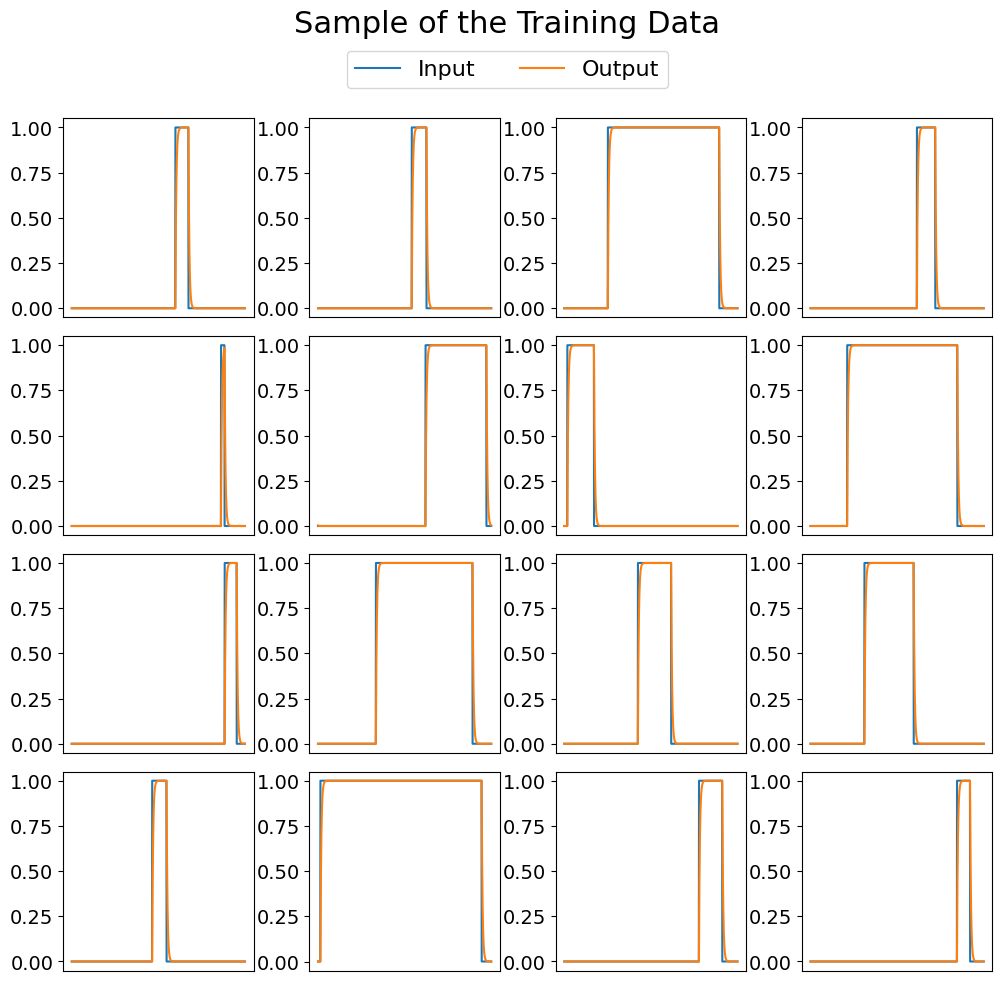

In [4]:
plot_data(train_x, train_y, name= "Sample of the Training Data")

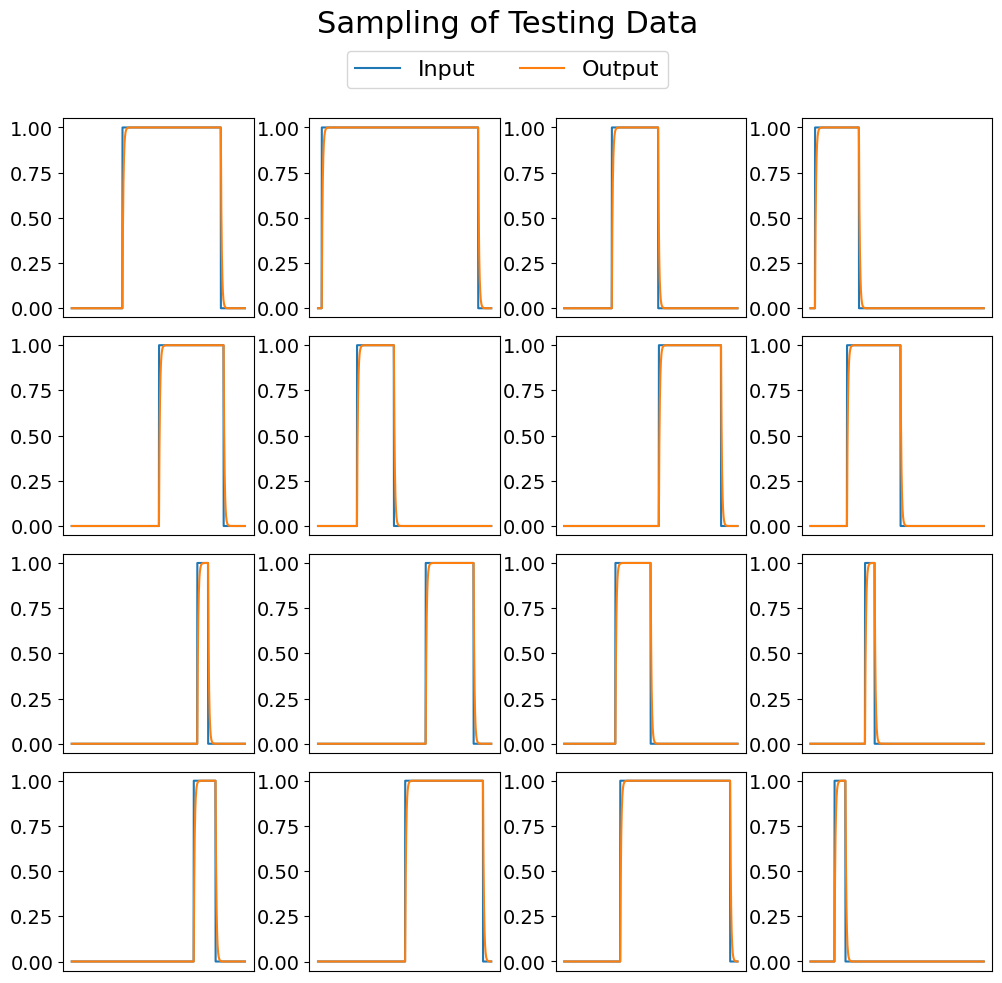

In [5]:
plot_data(test_x, test_y, name = "Sampling of Testing Data")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_x = torch.Tensor(train_x[:,np.newaxis,:]).to(device)
train_y = torch.Tensor(train_y[:,np.newaxis,:]).to(device)
test_x = torch.Tensor(test_x[:,np.newaxis,:]).to(device)
test_y = torch.Tensor(test_y[:,np.newaxis,:]).to(device)

out_of_dist_x = torch.Tensor(out_of_dist_x[:,np.newaxis,:]).to(device)
out_of_dist_y = torch.Tensor(out_of_dist_y[:,np.newaxis,:]).to(device)
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

## Setting Up First Model


In [7]:
import torch
import torch.nn as nn
import torch.fft

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

class SpectralConv1d(nn.Module):
    def __init__(self, 
                 in_channels : int, 
                 out_channels: int, 
                 modes: int):
        """
        Initializes a 1D spectral convolution layer using complex weights in the Fourier domain.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            modes (int): Number of Fourier modes to retain (low-frequency modes).
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        scale = 1.0 / (in_channels * out_channels)
        self.real_weights = nn.Parameter(
            torch.rand(in_channels, out_channels, modes) * 2 * scale - scale
        )
        self.imag_weights = nn.Parameter(
            torch.rand(in_channels, out_channels, modes) * 2 * scale - scale
        )

    def complex_mult1d(self, x_hat, w):
        return torch.einsum("iM,ioM->oM", x_hat, w)

    def forward(self, x):
        # x: (batch, channels, spatial_points)
        batchsize, channels, spatial_points = x.shape

        x_hat = torch.fft.rfft(x, dim=-1)  # (B, C, F)
        x_hat_under_modes = x_hat[:, :, :self.modes]

        weights = torch.complex(self.real_weights, self.imag_weights)
        out_hat_under_modes = torch.einsum("bim, iom -> bom", x_hat_under_modes, weights)

        out_hat = torch.zeros(
            batchsize, self.out_channels, x_hat.shape[-1],
            dtype=torch.cfloat, device=x.device
        )
        out_hat[:, :, :self.modes] = out_hat_under_modes

        out = torch.fft.irfft(out_hat, n=spatial_points, dim=-1)
        return out


class FNOBlock1d(nn.Module):
    def __init__(self, 
                 in_channels : int, 
                 out_channels : int, 
                 modes : int, 
                 activation : nn.Module = nn.Identity(),
                 adaptive: bool = False):
        """
        Initializes a single Fourier Neural Operator (FNO) block for 1D data.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            modes (int): Number of retained Fourier modes in the spectral convolution.
            activation (nn.Module, optional): Activation function applied after the block output. Default is nn.Identity().
        """
        
        super().__init__()

        self.activation = activation

        self.spectral_conv = SpectralConv1d(in_channels, out_channels, modes)
        self.bypass_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        sc = self.spectral_conv(x)
        bc = self.bypass_conv(x)
        out = sc + bc
        return self.activation(out)

class ConvNet1d(nn.Module):
    """
    A simple 1D convolutional network with a hidden layer and activation.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        activation (nn.Module, optional): Activation function between the convolutional layers. Default is nn.Identity().
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 activation: nn.Module = nn.Identity()):
        super().__init__()


        self.net = nn.Sequential(nn.Conv1d(in_channels, out_channels, kernel_size = 1, bias = False),
                                     activation)

    def forward(self, x):
        return self.net(x)

class FNO1d(nn.Module):
    def __init__(
        self,
        in_channels : int,
        out_channels : int,
        modes : int,
        width : int,
        block_activation : nn.Module = nn.Identity(),
        n_blocks : int = 4,
        lift_activation : nn.Module = nn.Identity(),
        decode_activation : nn.Module = nn.Identity(),
    ):
        """
        Initializes a 1D Fourier Neural Operator (FNO) model.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            modes (int): Number of Fourier modes retained in spectral convolutions.
            width (int): Width of the internal FNO layers.
            block_activation (nn.Module, optional): Activation applied after each FNO block. Default is nn.Identity().
            n_blocks (int, optional): Number of stacked FNO blocks. Default is 4.
            lift_activation (nn.Module, optional): Activation function for the lifting network. Default is nn.Identity().
            decode_activation (nn.Module, optional): Activation function for the decoding network. Default is nn.Identity().
        """

        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.width = width
        self.block_activation = block_activation
        self.n_blocks = n_blocks
        self.lift_activation = lift_activation
        self.decode_activation = decode_activation


        self.lift_network = ConvNet1d(in_channels = self.in_channels, 
                                        out_channels = self.width, 
                                        activation = self.lift_activation)
                    
        self.decode_network = ConvNet1d(self.width,
                                        self.out_channels,
                                        self.decode_activation)

        self.fno_blocks = nn.ModuleList([
            FNOBlock1d(width, width, modes, block_activation)
            for _ in range(n_blocks)
        ])

        self.apply(init_weights)

    # x: (B, C, N)
    def forward(self, x):

        x = self.lift_network(x)

        for block in self.fno_blocks:
            x = block(x)

        x = self.decode_network(x)

        return x

In [8]:
torch.manual_seed(0)
first_fno = FNO1d(in_channels = 1,
                  out_channels = 1,
                  modes = 32,
                  width = 8,
                  n_blocks = 1,
                  )

In [9]:
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
from typing import Tuple

def train_loop(model: nn.Module,
               train_loader: DataLoader,
               val_x: torch.Tensor,
               val_y: torch.Tensor,
               epochs: int,
               optimizer: Optimizer,
               scheduler: _LRScheduler,
               criterion: nn.modules.loss._Loss = nn.MSELoss(),
               save_results: bool = True,
               verbose: bool = False,
               sample_freq: int = 1) -> Tuple[list, list]:
    """
    Runs the training loop for a specified number of epochs.

    For each epoch, trains the model on the training data with optional noise and downsampling,
    applies gradient clipping, updates optimizer and scheduler, and evaluates on validation data.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader providing training batches.
        val_x (torch.Tensor): Validation input data.
        val_y (torch.Tensor): Validation target data.
        optimizer (Optimizer): Optimizer instance to update model parameters.
        scheduler (_LRScheduler): Learning rate scheduler.
        epochs (int): Number of epochs to train.
        criterion (nn.modules.loss._Loss, optional): Loss function. Defaults to MSELoss.
        save_results (bool, optional): Whether to save loss history each epoch. Defaults to True.

    Returns:
        Tuple[list, list]: Tuple containing training loss history and validation loss history.
    """
    
    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            
            output = model(batch_x[:,:,::sample_freq])
            loss = criterion(output, batch_y[:,:,::sample_freq])

            loss.backward()

            optimizer.step()
            epoch_loss += loss.item()
            scheduler.step()

        if save_results or epoch == epochs -1:
            loss_history.append(epoch_loss / len(train_loader))
            
            model.eval()
            with torch.no_grad():
                val_output = model(val_x)
                val_loss = criterion(val_output, val_y).item()
                val_loss_history.append(val_loss)

            if verbose:
                print(f"EPOCH {epoch}: train_loss: {loss.item():.3e} \t test_loss: {val_loss:.3e}")

    return loss_history, val_loss_history

In [10]:
optimizer = optim.Adam(first_fno.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)

loss_history, val_loss_history = train_loop(model = first_fno,
                                            train_loader=train_loader,
                                            val_x = test_x,
                                            val_y = test_y,
                                            epochs = 20,
                                            optimizer= optimizer,
                                            scheduler = scheduler,
                                            verbose = True,
                                            sample_freq = 4)

EPOCH 0: train_loss: 3.718e-02 	 test_loss: 2.484e-02
EPOCH 1: train_loss: 1.237e-02 	 test_loss: 1.378e-02
EPOCH 2: train_loss: 5.309e-03 	 test_loss: 4.593e-03
EPOCH 3: train_loss: 4.870e-03 	 test_loss: 5.197e-03
EPOCH 4: train_loss: 4.597e-03 	 test_loss: 4.458e-03
EPOCH 5: train_loss: 3.942e-03 	 test_loss: 3.968e-03
EPOCH 6: train_loss: 3.903e-03 	 test_loss: 3.960e-03
EPOCH 7: train_loss: 3.974e-03 	 test_loss: 3.948e-03
EPOCH 8: train_loss: 3.859e-03 	 test_loss: 3.924e-03
EPOCH 9: train_loss: 3.872e-03 	 test_loss: 3.909e-03
EPOCH 10: train_loss: 3.895e-03 	 test_loss: 3.900e-03
EPOCH 11: train_loss: 3.816e-03 	 test_loss: 3.895e-03
EPOCH 12: train_loss: 3.910e-03 	 test_loss: 3.892e-03
EPOCH 13: train_loss: 3.956e-03 	 test_loss: 3.890e-03
EPOCH 14: train_loss: 3.939e-03 	 test_loss: 3.889e-03
EPOCH 15: train_loss: 3.866e-03 	 test_loss: 3.888e-03
EPOCH 16: train_loss: 3.875e-03 	 test_loss: 3.887e-03
EPOCH 17: train_loss: 3.887e-03 	 test_loss: 3.887e-03
EPOCH 18: train_loss

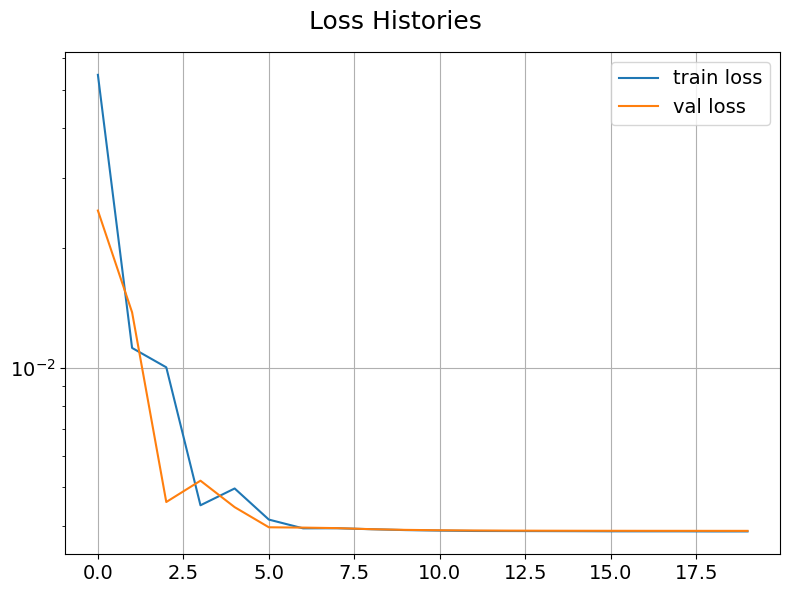

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(loss_history, label="train loss")
ax.plot(val_loss_history, label="val loss")
ax.legend(fontsize=14)
ax.set_yscale("log")
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=14)
fig.suptitle( "Loss Histories", fontsize=18)
plt.tight_layout()


In [14]:
def plot_results(model: torch.nn.Module, 
                 x: torch.Tensor, 
                 y: torch.Tensor, 
                 name: str) -> None:
    """
    Plot model predictions versus ground truth for 100 samples and save the figure.

    Args:
        model (torch.nn.Module): Trained model used for inference.
        x (torch.Tensor): Input tensor to generate predictions.
        y (torch.Tensor): Ground truth tensor for comparison.
        name (str): Filename to save the generated plot.
    """
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()
    for i in range(16):
        pred = model(x[i:i+1])[0].cpu().detach().numpy()
        ax1 = axes[i]

        ax1.plot(y[i, 0, :].cpu().detach().numpy(), color='tab:orange', label='Ground Truth' if i == 0 else "")
        ax1.plot(pred[0], color='tab:green', label='Prediction' if i == 0 else "")
        ax1.set_xticks([])
        ax1.set_yticks([])

    fig.suptitle(name, fontsize=22, y=0.98)  # Title closer to top

    # Legend below the title, slightly lower than before
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend on top

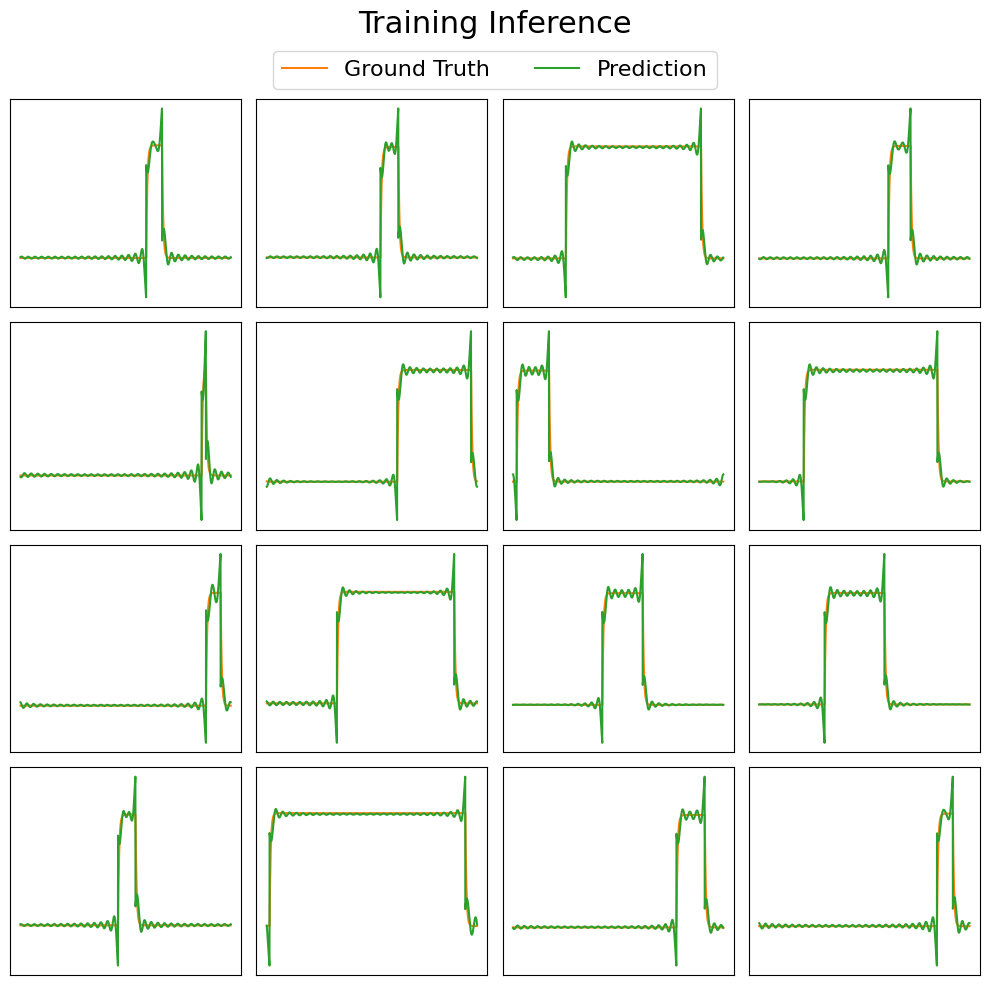

In [15]:
plot_results(first_fno, train_x, train_y, name = "Training Inference");

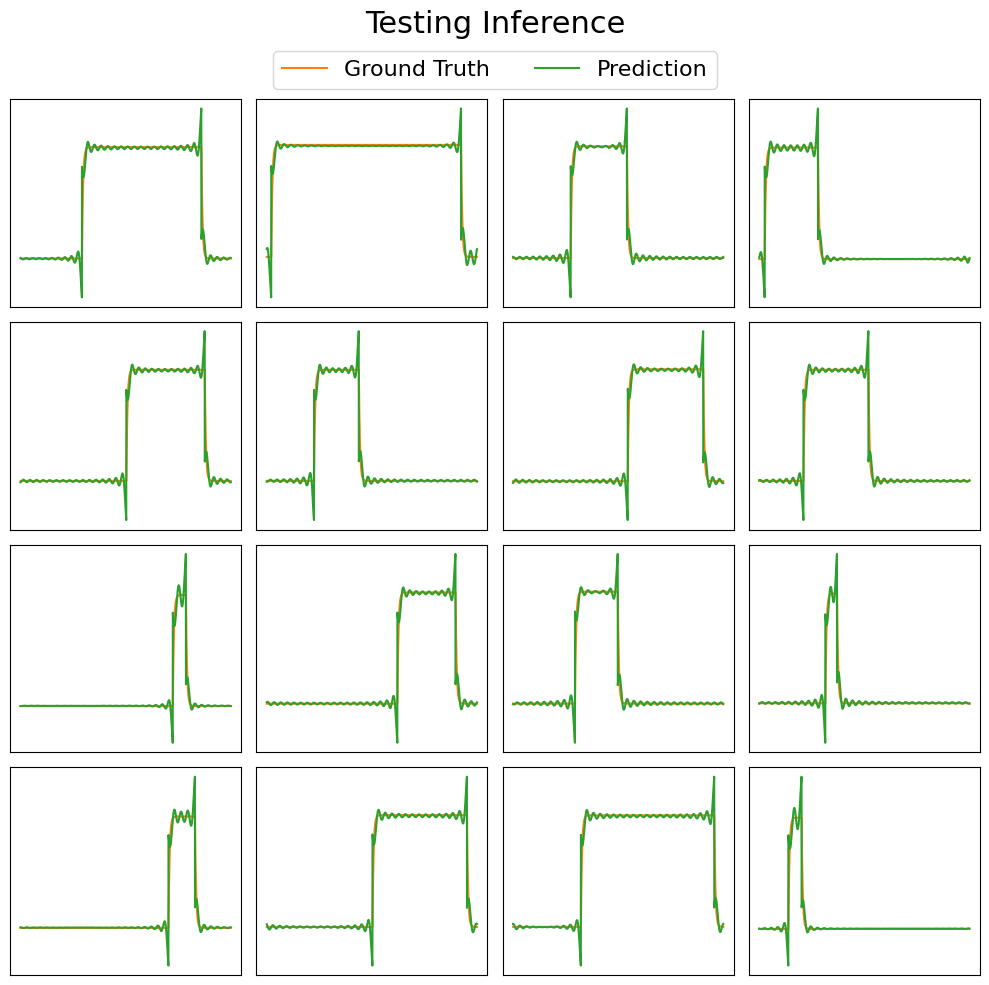

In [16]:
plot_results(first_fno, test_x, test_y, name = "Testing Inference");

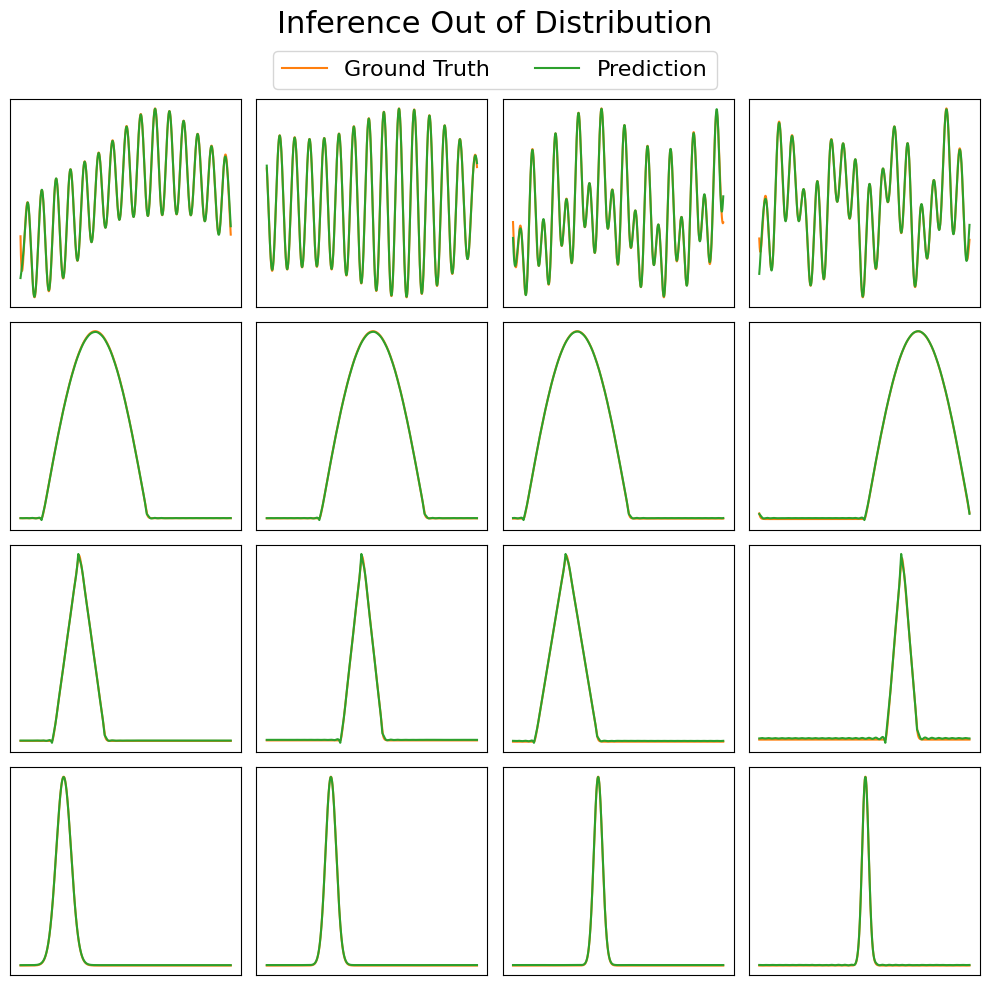

In [17]:
plot_results(first_fno, out_of_dist_x, out_of_dist_y, name = "Inference Out of Distribution");

In [19]:
import ipywidgets as widgets

def interactive_sampling_plot(model, train_x, train_y, test_x, test_y, out_of_dist_x, out_of_dist_y, training_resolution, modes):
    """
    Interactive plot of FNO predictions for multiple samples with variable upsampling and downsampling.
    Each tab contains four rows of chosen samples. The first subplot uses an interactive upsample slider, 
    the second uses the training resolution, the third uses an interactive downsample slider, and the fourth shows an overlay.
    """

    # Hardcoded samples
    out_of_dist_to_plot = [
        (out_of_dist_y[0,0,:], out_of_dist_x[0,0,:]),
        (out_of_dist_y[4,0,:], out_of_dist_x[4,0,:]),
        (out_of_dist_y[8,0,:], out_of_dist_x[8,0,:]),
        (out_of_dist_y[12,0,:], out_of_dist_x[12,0,:])
    ]

    train_to_plot = [
        (train_y[0,0,:], train_x[0,0,:]),
        (train_y[1,0,:], train_x[1,0,:]),
        (train_y[2,0,:], train_x[2,0,:]),
        (train_y[3,0,:], train_x[3,0,:])
    ]

    test_to_plot = [
        (test_y[0,0,:], test_x[0,0,:]),
        (test_y[1,0,:], test_x[1,0,:]),
        (test_y[2,0,:], test_x[2,0,:]),
        (test_y[3,0,:], test_x[3,0,:])
    ]

    def plot_samples(tab_name, upsample_factor, downsample_factor):
        if tab_name == "Train":
            samples = train_to_plot
        elif tab_name == "Test":
            samples = test_to_plot
        elif tab_name == "OOD":
            samples = out_of_dist_to_plot
        else:
            return

        fig, axes = plt.subplots(len(samples), 4, figsize=(16, 3*len(samples)))

        if len(samples) == 1:
            axes = axes[np.newaxis, :]  # Ensure 2D array for consistency

        for row_idx, (y_sample, x_sample) in enumerate(samples):
            # Subplot 1: Upsampled at slider value
            real_upsample_factor = training_resolution - upsample_factor if upsample_factor - training_resolution != 0 else 1
            axes[row_idx, 0].scatter(np.linspace(0,1,len(x_sample[::real_upsample_factor])), x_sample[::real_upsample_factor], label="Input x")
            axes[row_idx, 0].plot(np.linspace(0,1,len(y_sample[::real_upsample_factor])),
                                   model(x_sample[None,None,::real_upsample_factor])[0][0].cpu().detach().numpy(),
                                   color='red', label="Prediction")
            axes[row_idx, 0].set_title(f"Upsampled at x {upsample_factor}" if row_idx==0 else "")
            axes[row_idx, 0].legend()

            # Subplot 2: Sampled at training_resolution
            axes[row_idx, 1].scatter(np.linspace(0,1,len(x_sample[::training_resolution])), x_sample[::training_resolution], label="Input x")
            axes[row_idx, 1].plot(np.linspace(0,1,len(y_sample[::training_resolution])),
                                   model(x_sample[None,None,::training_resolution])[0][0].cpu().detach().numpy(),
                                   color='red', label="Prediction")
            axes[row_idx, 1].set_title(f"Sampled at Training Resolution" if row_idx==0 else "")
            axes[row_idx, 1].legend()

            # Subplot 3: Downsampled at slider value
            real_downsample_factor = training_resolution * downsample_factor
            axes[row_idx, 2].scatter(np.linspace(0,1,len(x_sample[::real_downsample_factor])), x_sample[::real_downsample_factor], label="Input x")
            axes[row_idx, 2].plot(np.linspace(0,1,len(y_sample[::real_downsample_factor])),
                                   model(x_sample[None,None,::real_downsample_factor])[0][0].cpu().detach().numpy(),
                                   color='red', label="Prediction")
            axes[row_idx, 2].set_title(f"Downsampled at x {downsample_factor}" if row_idx==0 else "")
            axes[row_idx, 2].legend()

            # Subplot 4: Overlay of all resolutions + target y
            axes[row_idx, 3].plot(np.linspace(0,1,len(y_sample)), y_sample, color='black', linestyle='--', label="Target y")
            axes[row_idx, 3].plot(np.linspace(0,1,len(y_sample[::real_upsample_factor])), model(x_sample[None,None,::real_upsample_factor])[0][0].cpu().detach().numpy(), label=f"Upsampled {upsample_factor}")
            axes[row_idx, 3].plot(np.linspace(0,1,len(y_sample[::training_resolution])), model(x_sample[None,None,::training_resolution])[0][0].cpu().detach().numpy(), label=f"Sampled {training_resolution}")
            axes[row_idx, 3].plot(np.linspace(0,1,len(y_sample[::real_downsample_factor])), model(x_sample[None,None,::real_downsample_factor])[0][0].cpu().detach().numpy(), label=f"Downsampled {downsample_factor}")
            axes[row_idx, 3].set_title("Overlay" if row_idx==0 else "")
            if row_idx==0:
                axes[row_idx, 3].legend()

        plt.tight_layout()
        plt.show()

    tab_selector = widgets.Dropdown(
        options=["Train", "Test", "OOD"],
        value="OOD",
        description="Tab:"
    )
    upsample_slider = widgets.IntSlider(value=2, min=2, max=training_resolution, step=1, description="Upsample")
    downsample_slider = widgets.IntSlider(value= 4, min=2, max=int(2000/(2 *training_resolution * (modes+1))), step=1, description="Downsample")

    widgets.interact(plot_samples, tab_name=tab_selector, upsample_factor=upsample_slider, downsample_factor=downsample_slider)


In [20]:
interactive_sampling_plot(
    first_fno,
    train_x, train_y,
    test_x, test_y,
    out_of_dist_x, out_of_dist_y,
    training_resolution = 4,
    modes = 32
)

interactive(children=(Dropdown(description='Tab:', index=2, options=('Train', 'Test', 'OOD'), value='OOD'), In…

In [13]:
save_model(first_fno,"first_fno")

In [14]:

loaded_model = load_model('first_fno', device)

## Effect of Modes, Width, Number of Blocks, and Activation Functions on Final Model 

In [ ]:
interactive_training_ui(train_loader,
    train_x, train_y,
    test_x, test_y,
    out_of_dist_x, out_of_dist_y,
    epochs = 20
)
